<a href="https://colab.research.google.com/github/arielchernyy/FrontRunning/blob/main/front_running_ArielChernyy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**General logic of the proposed solution:**


According to my understanding, the essence of front-running is when a market participant from some source learns some information that is likely to influence the market substantially (move market prices in some direction), and buys/sells the asset to benefit from the future price movements that occur once the information becomes widely available. 


The data on stream of executed trades provided by Binance contains only information on price and volume of individual trades (probably Buyer/Seller order ID’s can be used to infer Buyers/Sellers, but I’m not sure), so we have to use only this information to decide on potential front-running cases. In other words, we need to find some anomalies in the flow of trades that can be considered to be front-running episodes.


New significant information becoming publicly available should lead to relatively large price movements (that’s once of the characteristics of “significance”). So, front-running is something that happens shortly before prices move relatively large. 


To truly benefit from having yet-private information, front-runners deals should probably be relatively large. So, we are looking for “unusually large deals happening shortly before prices move unusually large”.


In the code I define periods of unusually large price movements as a coincidence of to factors: relatively large on-off price move followed by a period of unchanged prices or prices going in the same direction (to distinguish between a sustained shift in prices and usual volatility). 
I use the following criteria: 1 period pct_change > *some cutoff* and MA_pct_change over next several periods > *some cutoff*. 


I use second-long intervals for BTCUSD, but the code can easily be extended for any time domain. 


Then, for relatively large trades, I look for trade volumes within several seconds (2 in the code, but can be modified) immediately before this unusual price move begins, that are larger than *some cutoff*


In the code for cutoffs I use different percentiles of the relevant data (e.g. 0.95 or 0.975 percentiles), but this is just an example using 10 minutes of data.


If a much longer time series were available, and if we had a set of confirmed front-runners deals, all the hyper-parameters could be fine-tuned (via grid search or genetic algorithm of some kind) to find optimal values resulting in the largest share of front-runners’ deals detected








In [3]:
pip install websocket-client

     |████████████████████████████████| 54 kB 2.3 MB/s 


In [4]:
import requests
import json
import websocket
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [5]:
# function to download stream of trades in instrument defined by *ticker* over period defined by *period*

def get_trade_data(ticker, period):
  
  socket = f'wss://stream.binance.com:9443 /ws/{ticker}t@trade'

  trade_data = dict()

  trade_data["Event type"] = []
  trade_data["Event time"] = []
  trade_data["Symbol"] = []
  trade_data["Trade ID"] = []
  trade_data["Price"] = []
  trade_data["Quantity"] = []
  trade_data["Buyer order ID"] = []
  trade_data["Seller order ID"] = []
  trade_data["Trade time"] = []
  trade_data["Is_Market_maker"] = []

  def on_message(ws, message):
    json_message = json.loads(message)
    trade_data["Event type"].append(json_message["e"])
    trade_data["Event time"].append(float(json_message["E"])/1000)
    trade_data["Symbol"].append(json_message["s"])
    trade_data["Trade ID"].append(json_message["t"])
    trade_data["Price"].append(float(json_message["p"]))
    trade_data["Quantity"].append(float(json_message["q"]))
    trade_data["Buyer order ID"].append(json_message["b"])
    trade_data["Seller order ID"].append(json_message["a"])
    trade_data["Trade time"].append(float(json_message["T"])/1000)
    trade_data["Is_Market_maker"].append(json_message["m"])

    if time.time() > start+period:
      ws.close()

  ws = websocket.WebSocketApp(socket, on_message=on_message)
  start = time.time()
  ws.run_forever()

  data = pd.DataFrame(trade_data)
  data['Trade time'] = pd.to_datetime(data['Trade time'], unit='s')

  return data


In [6]:
def find_suspicious_deals(ticker='btcusd', period=600, freq='1s', n_periods=5, 
                          cutoff_MA_min=0.05, cutoff_MA_max=0.95, cutoff_pct_min=0.05, cutoff_pct_max=0.95, 
                          cutoff_buys_MM=0.95, cutoff_buys_nonMM=0.95, cutoff_sells=0.975,
                          test_lag=2):
  
  data = get_trade_data(ticker, period) # source data, downloaded from binance by *ticker* and *period* arguments
  data['Trade volume'] = data['Price']*data['Quantity']

  # I aggregate data to get average price over periods specified by *freq* argument (default = 1 second)
  data_agg_price = data.groupby(by = pd.Grouper(key='Trade time', freq = freq)).agg(total_volume =('Trade volume','sum'), total_q = ('Quantity','sum'))
  data_agg_price['Avg_price'] = data_agg_price['total_volume']/data_agg_price['total_q']
  
  # I remove periods with no deals
  data_agg_price_clear = data_agg_price[data_agg_price['total_volume']>0]
  
  # I calculate price growth rates over periods and its moving average over window specified by *n_periods* argument (default = 5 seconds)
  data_agg_price_clear['price_change'] = data_agg_price_clear['Avg_price'].pct_change()
  data_agg_price_clear['price_change_MA'] = data_agg_price_clear['price_change'].rolling(n_periods).mean()

  # in the following calculation I'd need averagge price growth over next several periods (specified by same *n_periods* argument). 
  # these can be any other number of periods specified by new input argument
  data_agg_price_clear['price_change_MA_shift'] = np.nan
  data_agg_price_clear['price_change_MA_shift'].iloc[:-n_periods] = data_agg_price_clear['price_change_MA'].iloc[n_periods:]

  # I specify cutoff criteria to determine if price changes in current period and over next several periods are large enough to pay attention to this period.
  # given more historical data, these could be specified not as quantiles, but also explicitly 
  cutoff_MA_change_min, cutoff_MA_change_max = data_agg_price_clear['price_change_MA'].quantile(cutoff_MA_min), data_agg_price_clear['price_change_MA'].quantile(cutoff_MA_max)
  cutoff_pct_change_min, cutoff_pct_change_max = data_agg_price_clear['price_change'].quantile(cutoff_pct_min), data_agg_price_clear['price_change'].quantile(cutoff_pct_max)
  # and find periods with unusually high price moves
  data_agg_price_large_moves = data_agg_price_clear[((data_agg_price_clear['price_change']<cutoff_pct_change_min)&(data_agg_price_clear['price_change_MA_shift']<cutoff_MA_change_min))|
                                                    ((data_agg_price_clear['price_change']>cutoff_pct_change_max)&(data_agg_price_clear['price_change_MA_shift']>cutoff_MA_change_max))]
  
  # I keep only first points of the periods found on previous step
  periods_2_check = [data_agg_price_large_moves.index[0]]
  for i in range(1, len(data_agg_price_large_moves.index)):
    diff = data_agg_price_large_moves.index[i]-data_agg_price_large_moves.index[i-1]
    if diff.seconds>1:
      periods_2_check.append(data_agg_price_large_moves.index[i])
  
  # I calculate aggregate data on buy and sell orders
  data_buys = data.groupby(by = ['Buyer order ID', 'Is_Market_maker']).agg(total_volume =('Trade volume','sum'), total_q = ('Quantity','sum'), time_deal=('Trade time', 'min')).reset_index(level='Is_Market_maker')
  data_sells = data.groupby(by = ['Seller order ID', 'Is_Market_maker']).agg(total_volume =('Trade volume','sum'), total_q = ('Quantity','sum'), time_deal=('Trade time', 'min')).reset_index(level='Is_Market_maker')

  # I specify cutoff criteria to determine if buy/sell opereations were unusually large. I differentiate between market_makers and other market participants
  # given more historical data, these could be specified not as quantiles, but also explicitly
  buys_MM_cutoff = data_buys[data_buys['Is_Market_maker']==True]['total_q'].quantile(cutoff_buys_MM)
  buys_nonMM_cutoff = data_buys[data_buys['Is_Market_maker']==False]['total_q'].quantile(cutoff_buys_nonMM)
  sells_cutoff = data_sells['total_q'].quantile(cutoff_sells)

  # I look for unusually large buys or sells in the periods immediately preceding unusually large market moves
  suspicious_buys = []
  suspicious_sells = []

  test_period = datetime.timedelta(seconds=-test_lag)

  for elem in periods_2_check:
    if data_agg_price_clear.loc[elem]['price_change']>0:
      test_db = data_buys[(data_buys['time_deal']>=elem+test_period)&(data_buys['time_deal']<elem)]
      suspicious_buys += test_db[(test_db['total_q']>buys_MM_cutoff)&(test_db['Is_Market_maker']==True)].index.tolist()
      suspicious_buys += test_db[(test_db['total_q']>buys_nonMM_cutoff)&(test_db['Is_Market_maker']==False)].index.tolist()
    else: 
      test_db = data_sells[(data_sells['time_deal']>=elem+test_period)&(data_sells['time_deal']<elem)]
      suspicious_sells += test_db[test_db['total_q']>sells_cutoff].index.tolist()

  return data, data_agg_price_clear, data_buys, data_sells, suspicious_buys, suspicious_sells

In [7]:
data, data_agg_price_clear, data_buys, data_sells, suspicious_buys, suspicious_sells = find_suspicious_deals()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

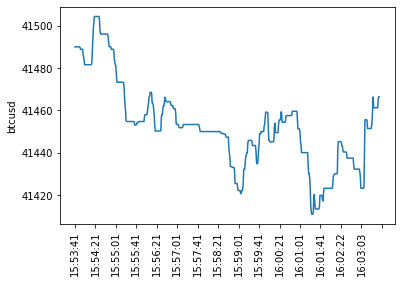

In [8]:
ax = plt.axes()
ax.plot(data_agg_price_clear.index.strftime("%H:%M:%S"), data_agg_price_clear['Avg_price'])
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(rotation=90)
plt.ylabel('btcusd')
plt.show()

In [9]:
data_buys.loc[suspicious_buys]

,Is_Market_maker,total_volume,total_q,time_deal
Buyer order ID,,,,
10235593367,False,9811.635752,0.23653,2022-04-19 15:54:14.303000064
10235593382,False,13751.555271,0.33151,2022-04-19 15:54:14.316999936
10235626914,False,38838.659881,0.93763,2022-04-19 15:59:09.140999936
10235658730,False,14843.607405,0.35834,2022-04-19 16:03:08.191000064
10235658738,False,15161.737965,0.36602,2022-04-19 16:03:08.253999872
10235658769,False,86883.195712,2.09745,2022-04-19 16:03:08.806999808
10235658770,False,16035.646007,0.38711,2022-04-19 16:03:08.812000000
10235658778,False,19944.418095,0.48147,2022-04-19 16:03:08.815000064
10235658794,False,11903.603514,0.28736,2022-04-19 16:03:08.819000064


In [10]:
data_sells.loc[suspicious_sells]

,Is_Market_maker,total_volume,total_q,time_deal
Seller order ID,,,,
10235608686,True,24926.744084,0.6011,2022-04-19 15:56:11.588999936


In [14]:
data[data['Buyer order ID'].isin(suspicious_buys)|data['Seller order ID'].isin(suspicious_sells)]

,Event type,Event time,Symbol,Trade ID,Price,Quantity,Buyer order ID,Seller order ID,Trade time,Is_Market_maker,Trade volume
278,trade,1.650384e+09,BTCUSDT,1329693926,41481.57,0.13651,10235593367,10235592519,2022-04-19 15:54:14.303000064,False,5662.649121
279,trade,1.650384e+09,BTCUSDT,1329693927,41481.57,0.03102,10235593367,10235592576,2022-04-19 15:54:14.303000064,False,1286.758301
280,trade,1.650384e+09,BTCUSDT,1329693928,41481.57,0.00030,10235593367,10235592701,2022-04-19 15:54:14.303000064,False,12.444471
281,trade,1.650384e+09,BTCUSDT,1329693929,41481.57,0.03000,10235593367,10235592716,2022-04-19 15:54:14.303000064,False,1244.447100
282,trade,1.650384e+09,BTCUSDT,1329693930,41481.57,0.03000,10235593367,10235592721,2022-04-19 15:54:14.303000064,False,1244.447100
...,...,...,...,...,...,...,...,...,...,...,...
7804,trade,1.650384e+09,BTCUSDT,1329701452,41423.74,0.00394,10235658770,10235658610,2022-04-19 16:03:08.812000000,False,163.209536
7805,trade,1.650384e+09,BTCUSDT,1329701453,41424.01,0.38117,10235658770,10235658286,2022-04-19 16:03:08.812000000,False,15789.589892
7806,trade,1.650384e+09,BTCUSDT,1329701454,41424.01,0.19383,10235658778,10235658286,2022-04-19 16:03:08.815000064,False,8029.215858
7807,trade,1.650384e+09,BTCUSDT,1329701455,41424.01,0.28764,10235658778,10235658296,2022-04-19 16:03:08.815000064,False,11915.202236
